In [133]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
color = sns.color_palette()
%matplotlib inline

In [43]:
x = 0
T = 1000
y = []
for t in range(T):
    x = np.random.normal(x, 0.05)
    y.append(np.random.normal(x, 0.5))
y = np.array(y)

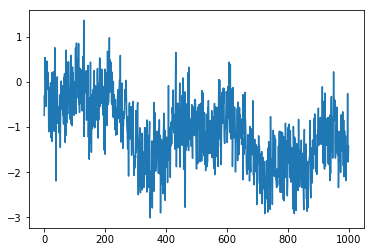

In [44]:
plt.plot(y)

In [71]:
def kalman_filter(y, sigma_eps, sigma_gamma, mu_init, sigma_init):
    T = len(y)
    mu = [mu_init]
    sigma = [sigma_init]
    for t in range(T):
        sigma.append(1 / (sigma[-1] + sigma_eps) + 1 / sigma_gamma)
        mu.append(mu[-1] + (sigma_eps + sigma[-1]) / (sigma_eps + sigma[-1] + sigma_gamma)*(y[t] -  mu[-1]))
        
    return mu, sigma

In [72]:
def kalman_smoother(y, x_filter, sigma_filter, sigma_eps, sigma_gamma):
    T = len(y)
    mu = [x_filter[-1]]
    sigma = [sigma_filter[-1]]
    for t in range(1, T + 1):
        mu.append(x_filter[T - t] + sigma_filter[T - t]/(sigma_filter[T - t] + sigma_eps) * (mu[-1] - x_filter[T - t]))
        sigma.append((sigma_filter[T - t]/(sigma_filter[T - t] + sigma_eps))**2 * sigma[-1] + sigma_filter[T-t]/(sigma_filter[T - t] + sigma_eps) * sigma_eps)
    return mu, sigma

In [73]:
def E_step(y, sigma_eps, sigma_gamma, mu_init, sigma_init):
    x_filter, sigma_filter = kalman_filter(y, sigma_eps, sigma_gamma, mu_init, sigma_init)
    x_smoother,_ = kalman_smoother(y, x_filter, sigma_filter, sigma_eps, sigma_gamma)
    
    return x_smoother[::-1], x_smoother[0]

In [74]:
def M_step(y, x_smoother):
    T = len(y)
    sigma_eps = sum((x_smoother[1:] - x_smoother[:T]) ** 2)/T
    sigma_gamma = sum((y - x_smoother[1:])**2)/(T + 1)
    return sigma_eps, sigma_gamma

In [104]:
def EM(y):
    sigma_eps_old = 0.01
    sigma_gamma_old = 0.1
    sigma_eps = 0.005
    sigma_gamma = 0.1
    mu_init = y[0]
    sigma_init = 0.01
    sigma_eps_ls = []
    sigma_gamma_ls = []
    while np.abs(sigma_eps_old - sigma_eps) > 1e-6 or np.abs(sigma_gamma_old - sigma_gamma) > 1e-6:
        sigma_eps_old = sigma_eps
        sigma_gamma_old = sigma_gamma
        x_smoother,mu_init = E_step(y, sigma_eps, sigma_gamma, mu_init, sigma_init)
        sigma_eps, sigma_gamma = M_step(y, np.array(x_smoother))
        sigma_eps_ls.append(sigma_eps)
        sigma_gamma_ls.append(sigma_gamma)
    
    return x_smoother, sigma_eps_ls, sigma_gamma_ls

In [105]:
x_smoother, sigma_eps_ls, sigma_gamma_ls = EM(y)

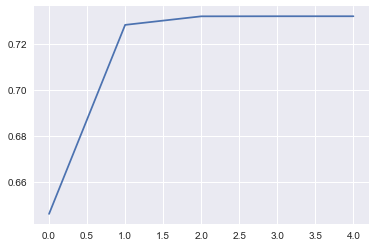

In [108]:
plt.plot(sigma_gamma_ls)

In [38]:
x_filter, sigma_filter = kalman_filter(y, 0.05, 0.5, y[0], 0.05)

In [39]:
x_smoother,_ = kalman_smoother(y, x_filter, sigma_filter, 0.05, 0.5)

In [87]:
df = pd.read_csv('cryptocurrencypricehistory-daily/bitcoin_price.csv')

In [88]:
df = df[::-1]

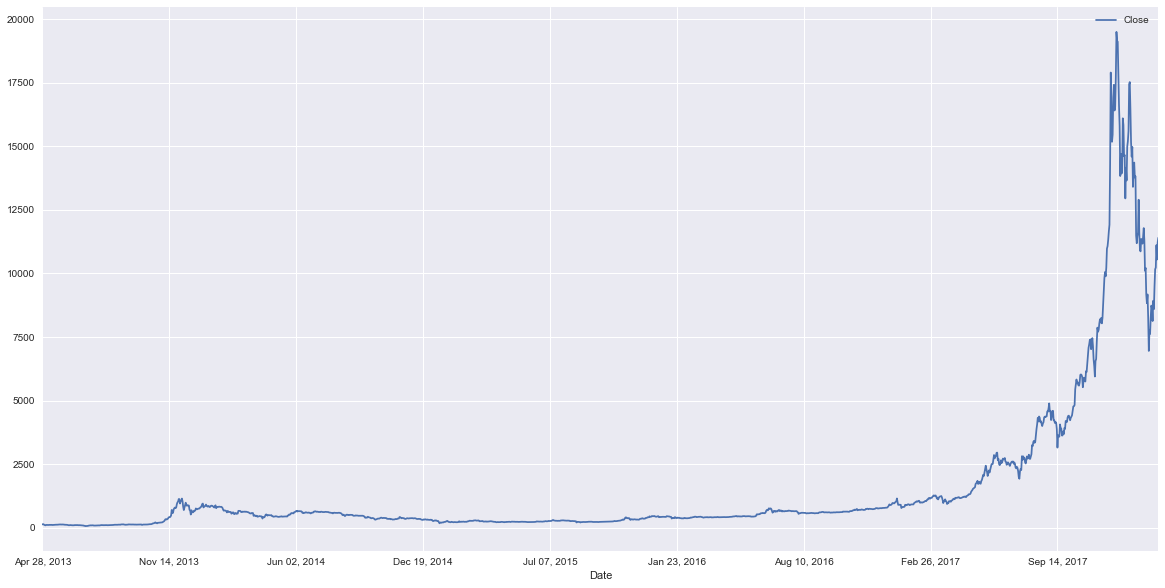

In [89]:
df.plot('Date', 'Close', figsize=(20,10))

In [83]:
price = df.Close.values

In [203]:
#price_ret = (price[1:] - price[:len(price) - 1]) / price[:len(price) - 1]
price_ret = np.log(price)

In [220]:
x_smoother, sigma_eps_ls, sigma_gamma_ls= EM(price_ret[:1500])

In [221]:
sigma_gamma_ls

[2.2381532837862386,
 2.8484482522417283,
 3.7443712534738443,
 3.6827550678762551,
 3.6868336902199572,
 3.686562744730205,
 3.6865807395132872,
 3.6865795443749168,
 3.686579623750927]

E[exp(X)]=exp(μ+σ2/2)

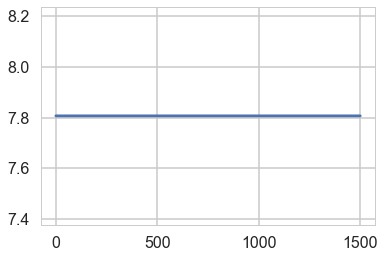

In [222]:
plt.plot(x_smoother[1:])

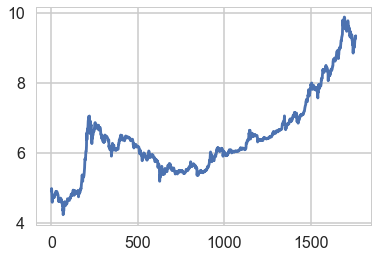

In [223]:
plt.plot(price_ret)

In [225]:
x_filter, sigma_filter = kalman_filter(price_ret[:1759], sigma_eps_ls[-1],  sigma_gamma_ls[-1], price_ret[0], sigma_gamma_ls[-1])

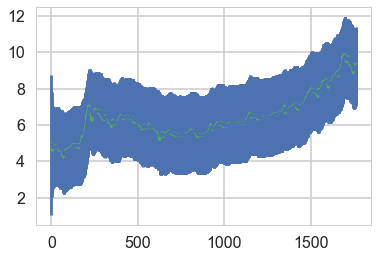

In [226]:
plt.errorbar(range(len(x_filter)), x_filter, yerr= 2 * np.sqrt(sigma_filter))
#plt.plot(price_ret[1000:1010])
plt.plot(price_ret[:1760])

In [246]:
np.sqrt(mean_squared_error(price_ret, x_filter))

0.072068795165417657

In [230]:
# compare with lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [238]:
# normalize the dataset
price_norm = price_ret.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price = scaler.fit_transform(price_norm)

In [239]:
# split into train and test sets
train_size = 1500
test_size = len(price) - train_size
train, test = price[0:train_size], price[train_size:len(price)]
print(len(train), len(test))

1500 260


In [240]:
# convert an array of values into a dataset matrix
def create_dataset(price, look_back=1):
    X = []
    for i in range(look_back):
        X.append(price[i : i + len(price) - look_back])
    X.append(price[look_back: len(price)])
    return X

In [241]:
# reshape into X=t and Y=t+1
look_back = 1
train = create_dataset(train, look_back)
test = create_dataset(test, look_back)

In [242]:
trainX = train[0]
trainY = train[1]
testX = test[0]
testY = test[1]

In [243]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [244]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 5s - loss: 0.0229
Epoch 2/10
 - 4s - loss: 0.0042
Epoch 3/10
 - 4s - loss: 2.6672e-04
Epoch 4/10
 - 4s - loss: 9.1547e-05
Epoch 5/10
 - 4s - loss: 8.8137e-05
Epoch 6/10
 - 4s - loss: 8.1218e-05
Epoch 7/10
 - 4s - loss: 7.7419e-05
Epoch 8/10
 - 4s - loss: 7.3923e-05
Epoch 9/10
 - 4s - loss: 7.1692e-05
Epoch 10/10
 - 4s - loss: 7.1782e-05


In [247]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [248]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.02 RMSE
